<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> AC295: Advanced Practical Data Science </h1>

## Intro to Transfer Learning

**Harvard University, Fall 2020**  
**Instructors**: Pavlos Protopapas  

---

#### Imports

In [1]:
import os
import requests
import zipfile
import shutil
import json
import time
import sys
import cv2
import numpy as np
import pandas as pd
from glob import glob
import subprocess
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from keras.utils.layer_utils import count_params

import tensorflow_hub as hub

from google.colab import auth
from google.cloud import storage

from sklearn.model_selection import train_test_split

#### Verify Setup

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells and record the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [2]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Hub version:", hub.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.3.0
keras version 2.4.0
Hub version: 0.9.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Run this cell to see what GPU you have. If you get a P100 or T4 GPU that's great. If it's K80, it will still work but it will be slow.

In [3]:
!nvidia-smi

Sat Oct 10 16:35:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |    227MiB / 15079MiB |      2%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Check Access to Bucket

In [4]:
# Authenticate
auth.authenticate_user()

In [5]:
# Check Bucket Access
bucket_name = "ac295-exercise4-xxu" # YOUR BUCKET NAME

# List buckets in a GCP project
storage_client = storage.Client(project="spry-equator-289113") # YOUR PROJECT ID 
buckets = list(storage_client.list_buckets())
print(buckets)

# Get bucket for Exercise 4
bucket = storage_client.get_bucket(bucket_name)
print("Exercise 4 Bucket:",bucket)

# Test Write access
test_file = "test-colab.txt"
with open(test_file, "w") as f:
  f.write("I have access!")

blob = bucket.blob(test_file) 
print('Uploading file', test_file)
blob.upload_from_filename(test_file)

# List contents of s bucket
blobs = bucket.list_blobs(prefix="", delimiter="/")
for blob in blobs:
  print(blob)

[<Bucket: ac295-exercise4-xxu>, <Bucket: ac295bucket1>, <Bucket: artifacts.spry-equator-289113.appspot.com>]
Exercise 4 Bucket: <Bucket: ac295-exercise4-xxu>
Uploading file test-colab.txt
<Blob: ac295-exercise4-xxu, dataset.zip, 1602323177239476>
<Blob: ac295-exercise4-xxu, test-colab.txt, 1602347738189395>
<Blob: ac295-exercise4-xxu, test-image-downloader.txt, 1602322690332224>


#### Utils

Here are some util functions that you will be using for this excercise

In [6]:
def download_file(packet_url, base_path="", extract=False):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)

# Get Dataset size
def get_dataset_size(base_path):
  dataset_folder_size = subprocess.check_output(['du','-sh', base_path]).split()[0].decode('utf-8')
  print("Dataset size on disk:")
  print("----------------")
  print("Total Size: ",dataset_folder_size)
  dataset_folder_size = dataset_folder_size.replace("G","000000000")
  dataset_folder_size = float(dataset_folder_size)

  dataset_file_list = glob(base_path+'/*')
  dataset_download_size = 0.0
  for file in dataset_file_list:
    if file.endswith(".zip"):
      dataset_download_size += os.path.getsize(file)

  dataset_download_size = dataset_download_size/1000000000
  dataset_size = dataset_folder_size - dataset_download_size

  print("Download Size: ",str(dataset_download_size)+"G")
  print("Dataset Size: ",str(dataset_size)+"G")

def get_dataset_list(base_path):
  # Labels
  label_names = os.listdir(base_path)

  # Generate a list of labels and path to images
  data_list = []
  for label in label_names:
      # Images
      image_files = os.listdir(os.path.join(base_path,label))
      data_list.extend([(label,os.path.join(base_path,label,f)) for f in image_files])

  return label_names, data_list

def compute_dataset_metrics(dataset_list):
  data_list_with_metrics = []
  for item in data_list:
    # Read image
    image = cv2.imread(item[1])
    data_list_with_metrics.append((item[0],item[1],image.shape[0],image.shape[1],image.nbytes / (1024 * 1024.0)))

  # Build a dataframe
  data_list_with_metrics = np.asarray(data_list_with_metrics)
  dataset_df = pd.DataFrame({
    'label': data_list_with_metrics[:, 0], 
    'path': data_list_with_metrics[:, 1],
    'height': data_list_with_metrics[:, 2],
    'width': data_list_with_metrics[:, 3],
    'size': data_list_with_metrics[:, 4],
    })
  
  dataset_df["height"] = dataset_df["height"].astype(int)
  dataset_df["width"] = dataset_df["width"].astype(int)
  dataset_df["size"] = dataset_df["size"].astype(float)

  dataset_mem_size = dataset_df["size"].sum()
  value_counts = dataset_df["label"].value_counts()
  height_details = dataset_df["height"].describe()
  width_details = dataset_df["width"].describe()

  print("Dataset Metrics:")
  print("----------------")
  print("Label Counts:")
  print(value_counts)
  print("Image Width:")
  print("Min:",width_details["min"]," Max:",width_details["max"])
  print("Image Height:")
  print("Min:",height_details["min"]," Max:",height_details["max"])
  print("Size in memory:",round(dataset_df["size"].sum(),2),"MB")

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

def save_model(path="models",model_name="model01"):

  # Ensure path exists
  if not os.path.exists(path):
      os.mkdir(path)

  # Save the enitire model (structure + weights)
  model.save(os.path.join(path,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(path,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(path,model_name+".json"), "w") as json_file:
      json_file.write(model_json)

def get_model_size(path="models",model_name="model01"):
  model_size = os.stat(os.path.join(path,model_name+".hdf5")).st_size
  return model_size

def evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print(evaluation_results)
  
  if save:
      # Save model
      save_model(model_name=model.name)
      model_size = get_model_size(model_name=model.name)

      # Save model history
      with open(os.path.join("models",model.name+"_train_history.json"), "w") as json_file:
          json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

      trainable_parameters = count_params(model.trainable_weights)
      non_trainable_parameters = count_params(model.non_trainable_weights)

      # Save model metrics
      metrics ={
          "trainable_parameters":trainable_parameters,
          "execution_time":execution_time,
          "loss":evaluation_results[0],
          "accuracy":evaluation_results[1],
          "model_size":model_size,
          "learning_rate":learning_rate,
          "batch_size":batch_size,
          "epochs":epochs,
          "optimizer":type(optimizer).__name__,
          "label_names": label_names,
          "name": model.name,
          "id": int(time.time())
      }
      with open(os.path.join("models",model.name+"_metrics.json"), "w") as json_file:
          json_file.write(json.dumps(metrics,cls=JsonEncoder))

## Download & Prepare Data



#### Download Data

In this step you will download the prepared dataset for this exercise. Optionaly if you prepared your own dataset feel free to use that here. 

In [7]:
start_time = time.time()
download_file("https://github.com/shivasj/dataset-store/releases/download/v1.0/vegetables.zip", base_path="datasets", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.3251719037691752


#### Explore Data

In [8]:
# Get the size of data in disk
get_dataset_size("datasets")

Dataset size on disk:
----------------
Total Size:  1.3G
Download Size:  0.650307325G
Dataset Size:  0.649692675G


Labels: ['beetroot', 'bell_pepper', 'broccoli', 'carrot', 'tomato']
[('beetroot', 'datasets/vegetables/beetroot/403.jpg'), ('beetroot', 'datasets/vegetables/beetroot/7.jpg'), ('beetroot', 'datasets/vegetables/beetroot/571.jpg'), ('beetroot', 'datasets/vegetables/beetroot/18.jpg'), ('beetroot', 'datasets/vegetables/beetroot/482.jpg')]


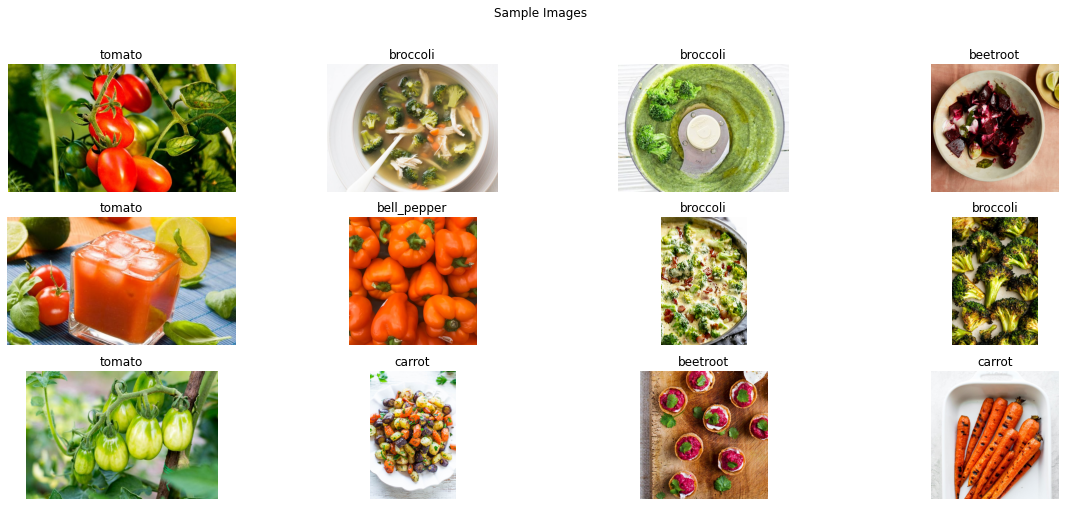

In [9]:
label_names, data_list = get_dataset_list("datasets/vegetables")
print("Labels:", label_names)
print(data_list[:5])

# View some images

# Generate a random sample of index
image_samples = np.random.randint(0,high=len(data_list)-1, size=12)

fig = plt.figure(figsize=(20,8))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(3,4,i+1)
    axs.set_title(data_list[img_idx][0])
    # Read image
    image = cv2.imread(data_list[img_idx][1])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()

In [10]:
compute_dataset_metrics(data_list)

Dataset Metrics:
----------------
Label Counts:
tomato         614
bell_pepper    583
carrot         582
broccoli       582
beetroot       573
Name: label, dtype: int64
Image Width:
Min: 146.0  Max: 5018.0
Image Height:
Min: 143.0  Max: 4160.0
Size in memory: 8659.75 MB


#### Build Data Pipelines 

For this section we will be using the `tf.data` API to build a simple but efficient data pipeline. The `tf.data` API enables you to build complex input pipelines from simple, reusable pieces. 

Input pipelines do not load all data to memory and streams data to the model as it is training. Pipelines can stream data from distributed file systems as well as local file systems. So in summary  `tf.data` API will help you as a Data Science Practioner to work with large amounts of data, read from different data formats, and perform complex transformations.


[Reference](https://www.tensorflow.org/guide/data)

In [12]:
# Load the dataset labels and image paths
label_names, data_list = get_dataset_list("datasets/vegetables")
print("Labels:", label_names)

# Number of unique labels
num_classes = len(label_names) 
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

print("Full size of the dataset:",len(data_list))
print(data_list[:5])

# Build data x, y
data_x = [x[1] for x in data_list]
data_y = [y[0] for y in data_list]

print("data_x:",data_x[:5])
print("data_y:",data_y[:5])

Labels: ['beetroot', 'bell_pepper', 'broccoli', 'carrot', 'tomato']
Full size of the dataset: 2934
[('beetroot', 'datasets/vegetables/beetroot/403.jpg'), ('beetroot', 'datasets/vegetables/beetroot/7.jpg'), ('beetroot', 'datasets/vegetables/beetroot/571.jpg'), ('beetroot', 'datasets/vegetables/beetroot/18.jpg'), ('beetroot', 'datasets/vegetables/beetroot/482.jpg')]
data_x: ['datasets/vegetables/beetroot/403.jpg', 'datasets/vegetables/beetroot/7.jpg', 'datasets/vegetables/beetroot/571.jpg', 'datasets/vegetables/beetroot/18.jpg', 'datasets/vegetables/beetroot/482.jpg']
data_y: ['beetroot', 'beetroot', 'beetroot', 'beetroot', 'beetroot']


In [15]:
test_percent = 0.10
validation_percent = 0.2

# Split data into train / test
train_validate_x, test_x, train_validate_y, test_y = train_test_split(data_x, data_y, test_size=test_percent)

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x, train_validate_y, test_size=validation_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))
print("test_x count:",len(test_x))

train_x count: 2112
validate_x count: 528
test_x count: 294


In [16]:
image_width = 224
image_height = 224
num_channels = 3
batch_size = 32
shuffle_buffer_size=3000 # For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

# Load Image
def load_image(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  return image, label

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]
test_processed_y = [label2index[label] for label in test_y]

# Converts to y to binary class matrix (One-hot-encoded)
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')
test_processed_y = to_categorical(test_processed_y, num_classes=num_classes, dtype='float32')

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))
test_data = tf.data.Dataset.from_tensor_slices((test_x, test_processed_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.map(load_image, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(normalize, num_parallel_calls=AUTOTUNE)
train_data = train_data.shuffle(buffer_size=shuffle_buffer_size)
train_data = train_data.batch(batch_size)

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.map(load_image, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(normalize, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.shuffle(buffer_size=shuffle_buffer_size)
validation_data = validation_data.batch(batch_size)

############
# Test data
############
# Apply all data processing logic
test_data = test_data.map(load_image, num_parallel_calls=AUTOTUNE)
test_data = test_data.map(normalize, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size)

print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

train_data <BatchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>
validation_data <BatchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>
test_data <BatchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>


## Build model without Transfer Learning

In [ ]:
# Build Model
def build_model_no_transfer_learning(image_height, image_width, num_channels, num_classes):

  # Set the model name as
  model_name = 'model_'+str(int(time.time()))

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels
  model_input = layers.Input(shape=input_shape)

  #################### Build Model ################################
  
  # Add First Convolution Block
  # Add 2 Conv2D layers with  filters=64, kernel_size=(3, 3), padding='same' and a suitable activation function
  # 1 MaxPooling2D layer with pool_size=(2, 2), strides=(2, 2)

  x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(model_input)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

  # Add Second Convolution Block
  # Add 2 Conv2D layers with  filters=128, kernel_size=(3, 3), padding='same' and a suitable activation function
  # 1 MaxPooling2D layer with pool_size=(2, 2), strides=(2, 2)

  x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same')(x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

  # Add Third Convolution Block
  # Add 2 Conv2D layers with  filters=256, kernel_size=(3, 3), padding='same' and a suitable activation function
  # 1 MaxPooling2D layer with pool_size=(2, 2), strides=(2, 2)

  x = layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same')(x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

  # Add Fourth Convolution Block
  # Add 2 Conv2D layers with  filters=512, kernel_size=(3, 3), padding='same' and a suitable activation function
  # 1 MaxPooling2D layer with pool_size=(2, 2), strides=(2, 2)

  x = layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same')(x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

  # Add Fifth Convolution Block
  # Add 2 Conv2D layers with  filters=512, kernel_size=(3, 3), padding='same' and a suitable activation function
  # 1 MaxPooling2D layer with pool_size=(2, 2), strides=(2, 2)

  x = layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same')(x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

  # Add Flatten Layer

  x = layers.Flatten()(x)

  #  Add Classification Block
  # Add 2 Dense layers with units=512 and a suitable activation function

  x = layers.Dense(units=512, activation='relu')(x)
  x = layers.Dense(units=512, activation='relu')(x)

  # Output Layer
  # Dense layer with units=num_classes, activation='softmax'
  x = layers.Dense(units=num_classes, activation='softmax')(x)

  # Create model with name=model_name
  model = Model(model_input, x, name=model_name)

  #################### Build Model ################################

  return model

(224, 224, 3, 5)
1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111
Model: "model_1602357213"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 128)     0        

66/66 [==============================] - 14s 206ms/step - loss: 1.6057 - accuracy: 0.2472 - val_loss: 1.5975 - val_accuracy: 0.3655
Epoch 2/10
66/66 [==============================] - 13s 203ms/step - loss: 1.5937 - accuracy: 0.3215 - val_loss: 1.5802 - val_accuracy: 0.3788
Epoch 3/10
66/66 [==============================] - 13s 203ms/step - loss: 1.5673 - accuracy: 0.3490 - val_loss: 1.5365 - val_accuracy: 0.2841
Epoch 4/10
66/66 [==============================] - 13s 204ms/step - loss: 1.5042 - accuracy: 0.3598 - val_loss: 1.4090 - val_accuracy: 0.4223
Epoch 5/10
66/66 [==============================] - 13s 204ms/step - loss: 1.3939 - accuracy: 0.4143 - val_loss: 1.4842 - val_accuracy: 0.3295
Epoch 6/10
66/66 [==============================] - 14s 205ms/step - loss: 1.2639 - accuracy: 0.4844 - val_loss: 1.2047 - val_accuracy: 0.5000
Epoch 7/10
66/66 [==============================] - 13s 204ms/step - loss: 1.1601 - accuracy: 0.5398 - val_loss: 1.0040 - val_accuracy: 0.5966
Epoch 8/10

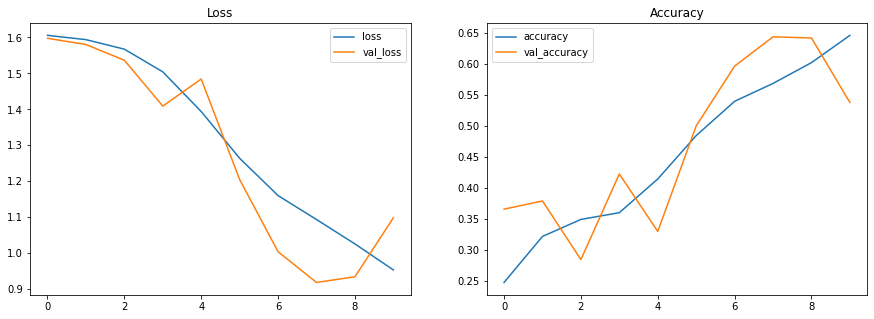

10/10 [==============================] - 2s 214ms/step - loss: 1.1480 - accuracy: 0.5442
[1.1479554176330566, 0.5442177057266235]


In [104]:

############################
# Training Params
############################
learning_rate = 0.01
epochs = 10

# Free up memory
K.clear_session()

print((image_height, image_width, num_channels, num_classes))
# Build the model
model = build_model_no_transfer_learning(image_height, image_width, num_channels, num_classes)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = optimizers.SGD(lr=learning_rate)

# Loss
loss = losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

## Transfer Learning using keras.application

In [105]:
# Build Model
def build_model_using_keras_application(image_height, image_width, num_channels, num_classes):

  # Set the model name as
  model_name = 'model_'+str(int(time.time()))

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels
  model_input = layers.Input(shape=input_shape)

  #################### Build Model ################################

  # Load a pretrained model from keras.applications
  #tranfer_model_base = keras.applications... (Use any pretrained model from keras.applications e,g: VGG, MobileNet, Resnet etc)

  # transferred = keras.applications.vgg16.VGG16(include_top=False, input_shape=input_shape)

  transferred = keras.applications.InceptionV3(include_top=False, input_shape=input_shape)

  # Set the tranfer_model_base trainable to False
  for layer in transferred.layers:
    layer.trainable = False

  # Regularize using L1
  kernel_weight = 0.02
  bias_weight = 0.02

  x = layers.Flatten()(transferred.layers[-1].output)

  # Add a classification head to tranfer_model_base 
  # 1 Dense layers with units=64, activation=relu,
  x = layers.Dense(units=64, activation='relu')(x)

  # Output Layer
  # Dense layer with units=num_classes, activation='softmax'
  x = layers.Dense(units=num_classes, activation='softmax')(x)

  # For both the Dense layers add l1 regularization of 0.02 to both kernel and bias terms

  x.kernel_regularizer = regularizers.l1(kernel_weight)
  x.bias_regularizer = regularizers.l1(bias_weight)

  # Create model with name=model_name
  model = Model(inputs=transferred.inputs, outputs=x, name=model_name)

  #################### Build Model ################################

  return model

Model: "model_1602357518"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
___________________________________________________________________________________

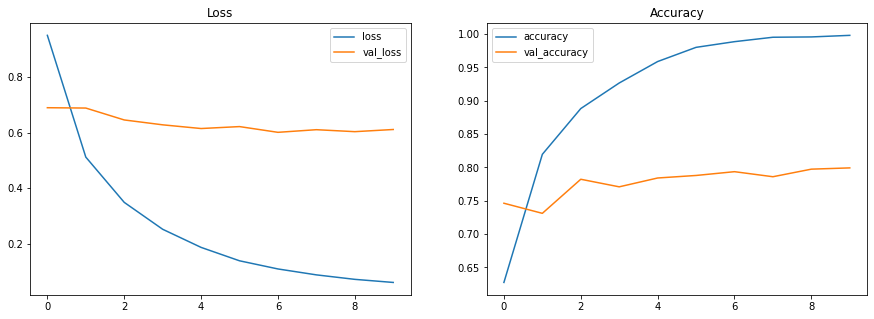

10/10 [==============================] - 2s 213ms/step - loss: 0.6277 - accuracy: 0.7857
[0.6277472376823425, 0.7857142686843872]


In [106]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 10

# Free up memory
K.clear_session()

# Build the model
model = build_model_using_keras_application(image_height, image_width, num_channels, num_classes)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = optimizers.SGD(lr=learning_rate)

# Loss
loss = losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

## Transfer Learning using TensorFlow Hub

[TensorFlow Hub](https://tfhub.dev/) is a repository where hundreds of machine learning models come together in one place

In [107]:
# Build Model
def build_model_using_tf_hub(image_height, image_width, num_channels, num_classes):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  ####
  # Use a different model here
  ####
  # Handle to pretrained model
  handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

  # Regularize using L1
  kernel_weight = 0.02
  bias_weight = 0.02

  model = Sequential([
        layers.InputLayer(input_shape=input_shape),
        hub.KerasLayer(handle, trainable=False),
        layers.Dense(units=64, activation='relu',
                               kernel_regularizer=regularizers.l1(kernel_weight), 
                               bias_regularizer=regularizers.l1(bias_weight)),
        layers.Dense(units=num_classes, activation='softmax',
                                  kernel_regularizer=tf.keras.regularizers.l1(kernel_weight), 
                                  bias_regularizer=tf.keras.regularizers.l1(bias_weight))
  ],name='model_'+str(int(time.time())))

  return model

Model: "model_1602357805"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 2,340,293
Trainable params: 82,309
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/10
66/66 [==============================] - 9s 130ms/step - loss: 56.2657 - accuracy: 0.2652 - val_loss: 54.9846 - val_accuracy: 0.3598
Epoch 2/10
66/66 [==============================] - 8s 123ms/step - loss: 53.8369 - accuracy: 0.4754 - val_loss: 52.6511 - val_accuracy: 0.5398
Epoch 3/10
66/66 [==============================] - 8s 120ms/step - loss

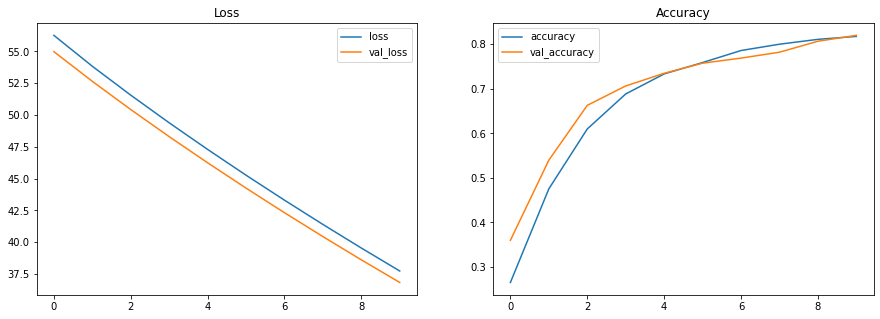

10/10 [==============================] - 2s 212ms/step - loss: 36.8126 - accuracy: 0.8231
[36.81256866455078, 0.8231292366981506]


In [108]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 10

# Free up memory
K.clear_session()

# Build the model
model = build_model_using_tf_hub(image_height, image_width, num_channels, num_classes)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = optimizers.SGD(lr=learning_rate)

# Loss
loss = losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

## Select best Model

#### Compare all Models

In [109]:
models_store_path = "models"

models_metrics_list = glob(models_store_path+"/*_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    #model_metrics["name"] = mm_file.replace("models/","").replace("_metrics.json","")
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.0f} MB'.format)

# Filter columns
view_metrics = view_metrics[["trainable_parameters","execution_time","loss","accuracy","model_size","learning_rate","epochs","optimizer","name"]]
view_metrics = view_metrics.sort_values(by=['accuracy'],ascending=False)
view_metrics.head(10)

,trainable_parameters,execution_time,loss,accuracy,model_size,learning_rate,epochs,optimizer,name
1,"82,309",4.08 mins,36.81,82.31%,10 MB,0.001,10,SGD,model_1602357805
2,"3,277,189",2.34 mins,0.60,78.57%,101 MB,0.001,5,SGD,model_1602355495
6,"3,277,189",4.63 mins,0.63,78.57%,101 MB,0.001,10,SGD,model_1602357518
0,"82,309",2.10 mins,46.03,75.17%,10 MB,0.001,5,SGD,model_1602355871
4,"1,606,021",2.57 mins,1.01,65.99%,65 MB,0.001,5,SGD,model_1602355133
5,"17,021,573",5.02 mins,1.15,54.42%,68 MB,0.010,10,SGD,model_1602357213
3,"17,021,573",2.41 mins,1.42,31.97%,68 MB,0.010,5,SGD,model_1602352390


In [110]:
models_metrics_list

['models/model_1602355871_metrics.json',
 'models/model_1602357805_metrics.json',
 'models/model_1602355495_metrics.json',
 'models/model_1602352390_metrics.json',
 'models/model_1602355133_metrics.json',
 'models/model_1602357213_metrics.json',
 'models/model_1602357518_metrics.json']

#### Save Best Model

In [111]:
# Selecting the best model based on accuracy
best_model = view_metrics.iloc[0]["name"]
print("Best model:",best_model)

best_model_path = "best_model"
shutil.rmtree(best_model_path, ignore_errors=True)
os.mkdir(best_model_path)

bucket = storage_client.get_bucket(bucket_name)
for file_path in glob('models/'+best_model+'*.*'):
  print(file_path)
  file_name = os.path.basename(file_path)
  file_name = file_name.replace(best_model,"model")
  shutil.copy(file_path,os.path.join(best_model_path,file_name))

# Copy the best model to GCP Bucket
for file_path in glob(best_model_path+'/*'):
  print(file_path)
  blob = bucket.blob(file_path) 
  print('uploading file', file_path)
  blob.upload_from_filename(file_path)

Best model: model_1602357805
models/model_1602357805.hdf5
models/model_1602357805.json
models/model_1602357805.h5
models/model_1602357805_metrics.json
models/model_1602357805_train_history.json
best_model/model.h5
uploading file best_model/model.h5
best_model/model_train_history.json
uploading file best_model/model_train_history.json
best_model/model.hdf5
uploading file best_model/model.hdf5
best_model/model.json
uploading file best_model/model.json
best_model/model_metrics.json
uploading file best_model/model_metrics.json
